# Analysis

### Abstract
Dataset describes Portugal bank marketing campaigns results where campaigns were based mostly on direct phone calls, offering  bank's clients to place a term deposit. 
If after all marking afforts client had agreed to place deposit - target variable marked 'yes', otherwise 'no'.

### Task

* (Classification) predicting the future results of marketing companies based on available statistics and, accordingly, formulating recommendations for such companies in the future.
* Build profile of a consumer of banking services (deposits).
* (KNN-Clustering) To create an imaginary boundary to classify the data. When new data points come in, the algorithm will try to predict that to the nearest of the boundary line.


### Feature description
**Bank client data:**
* 1 - age (numeric)
* 2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
* 3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
* 4 - education (categorical: basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
* 5 - default: has credit in default? (categorical: 'no','yes','unknown')
* 6 - housing: has housing loan? (categorical: 'no','yes','unknown')
* 7 - loan: has personal loan? (categorical: 'no','yes','unknown')

***Related with the last contact of the current campaign:***
* 8 - contact: contact communication type (categorical: 'cellular','telephone')
* 9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
* 10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
* 11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

***other attributes:***
* 12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
* 13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
* 14 - previous: number of contacts performed before this campaign and for this client (numeric)
* 15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

***social and economic context attributes***
* 16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
* 17 - cons.price.idx: consumer price index - monthly indicator (numeric)
* 18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
* 19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
* 20 - nr.employed: number of employees - quarterly indicator (numeric)

***Output variable (desired target):***
* 21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

In [ ]:
import pandas as pd
import numpy as np
import time
import gc
import warnings
!pip install category-encoders
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from tqdm import tqdm
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer,SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn import set_config
from sklearn.metrics import accuracy_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Source of Dataset:
https://github.com/llhthinker/MachineLearningLab/raw/master/UCI%20Bank%20Marketing%20Data%20Set/data/bank-additional/bank-additional-full.csv

Sourse of the data:
https://archive.ics.uci.edu/ml/datasets/bank+marketing

In [ ]:
data = pd.read_csv('https://github.com/llhthinker/MachineLearningLab/raw/master/UCI%20Bank%20Marketing%20Data%20Set/data/bank-additional/bank-additional-full.csv', sep=';')
display(data.head(3))
display('{} observations and {} features'.format(data.shape[0], data.shape[1]))

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


'41188 observations and 21 features'

### 1. Explore categorical features (EDA)

In [ ]:
# show categorical values disribution
def plot_bar(column):
    # temp df 
    temp_1 = pd.DataFrame()
    temp_1['No_deposit'] = data[data['y'] == 'no'][column].value_counts()
    temp_1['Yes_deposit'] = data[data['y'] == 'yes'][column].value_counts()
    temp_1.plot(kind='bar')
    plt.xlabel(f'{column}')
    plt.ylabel('Number of clients')
    plt.title('Distribution of {} and deposit'.format(column))
    plt.show();

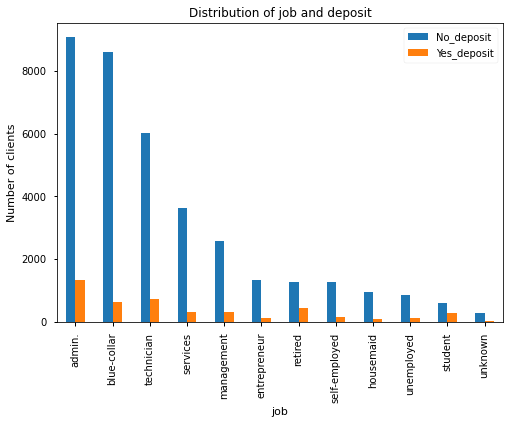

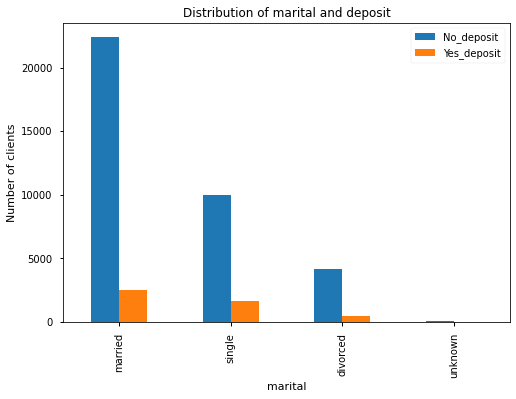

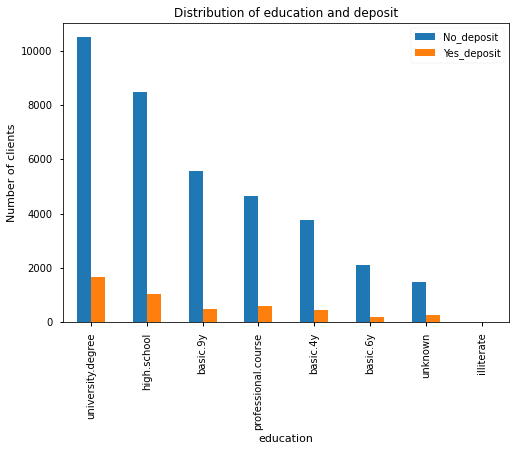

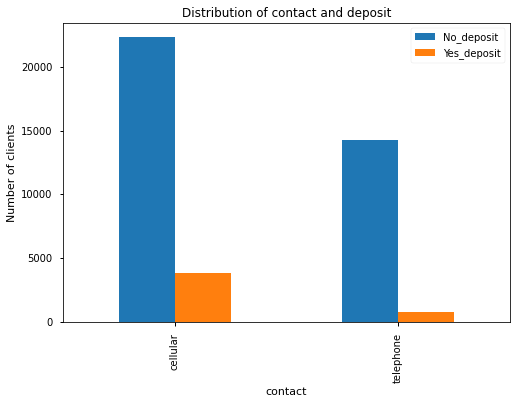

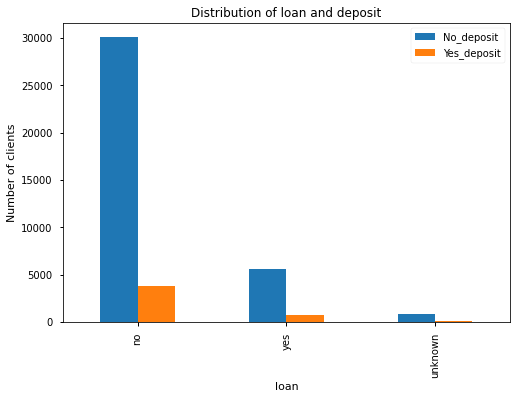

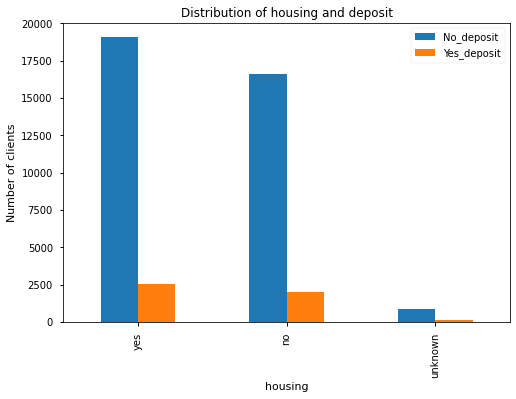

(None, None, None, None, None, None)

In [ ]:
plt.style.use('seaborn-notebook')
plot_bar('job'), plot_bar('marital'), plot_bar('education'), plot_bar('contact'), plot_bar('loan'), plot_bar('housing')

**Primary analysis of several categorical features reveals:**
1. Best communication channel is cellular.
2. Married consumers more often agreed to the service, in relative terms the single was responded better.
3. Home ownership does not greatly affect marketing company performance.
4. Administrative staff and technical specialists opened the deposit most of all. In relative terms, a high proportion of pensioners and students might be mentioned as well.

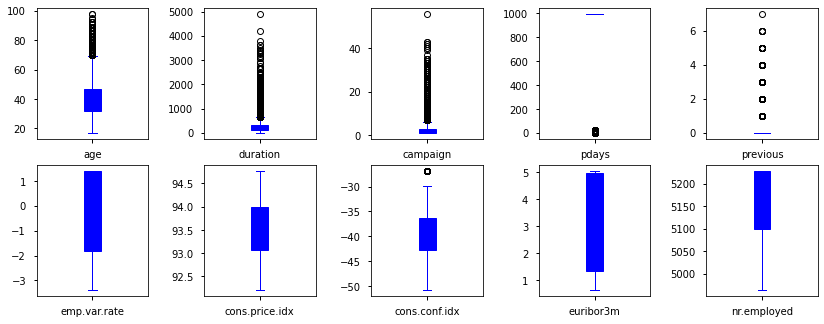

In [ ]:
numeric_data=data.select_dtypes(exclude=["object"])
numeric_data.plot(subplots =True, kind = 'box', layout = (5,5), figsize = (14,14),patch_artist=True,color="b")
plt.subplots_adjust(wspace = 0.5)

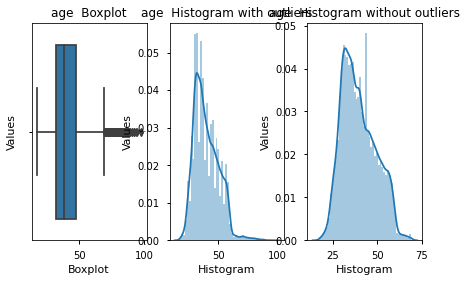

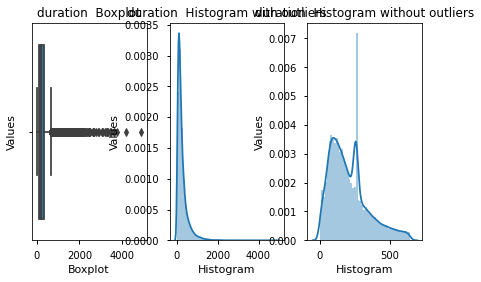

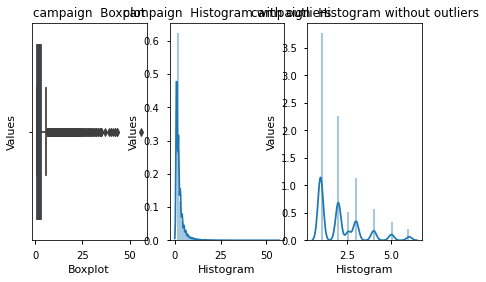

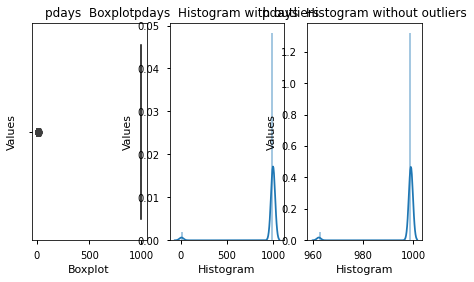

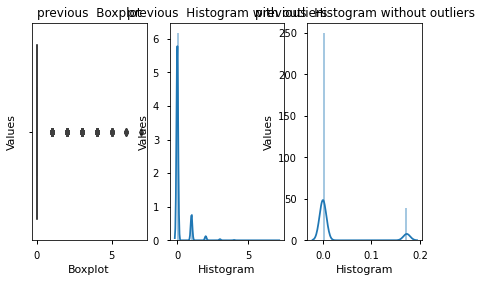

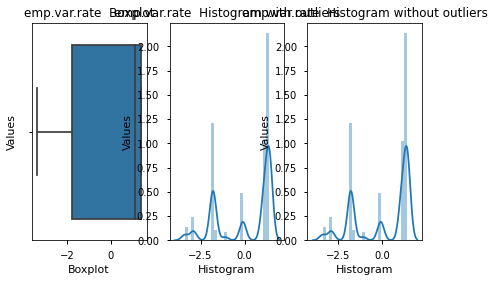

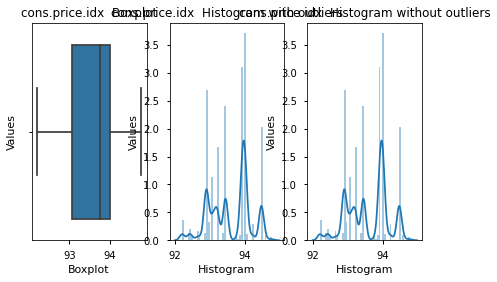

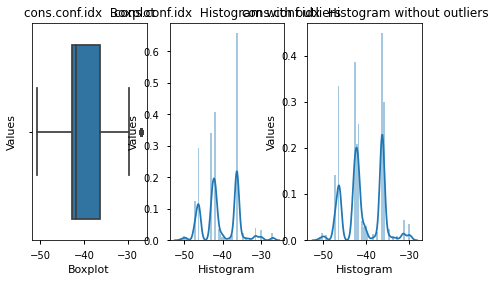

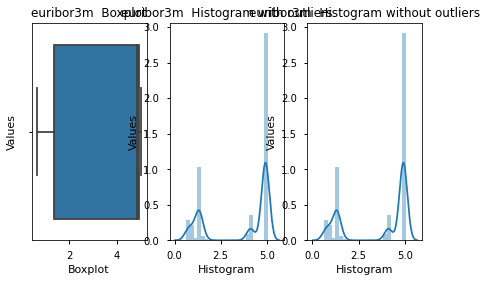

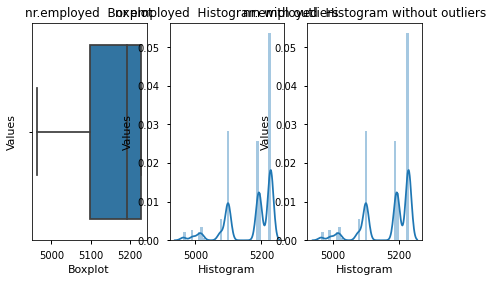

In [ ]:
#function to returns a df after treating the ouliers with median as strategy has best rep
def replace_outlier(df,col,method='quartile',strategy='mean'):
    col_data=df[col]
    if method=='quartile':
        q1=df[col].quantile(0.25)
        q2=df[col].quantile(0.5)
        q3=df[col].quantile(0.75)
        iqr=q3-q1
        lower_limit=q1-1.5*iqr          
        upper_limit=q3+1.5*iqr
        col_mean=df[col].mean()
    elif method=='std_dev':
        col_mean=df[col].mean()
        col_std_dev=df[col].std()
        lwr_limit=col_mean-2*col_std_dev
        upr_limit=col_mean+2*col_std_dev
    outliers=df.loc[(col_data < lower_limit)|(col_data > upper_limit),col]
    outliers_density=len(outliers)/len(df)
    if strategy=='median': 
        df.loc[(col_data < lower_limit)|(col_data > upper_limit),col]=q2  
    elif strategy=='mean':
        df.loc[(col_data < lower_limit)|(col_data > upper_limit),col]=col_mean
    return df

def odt_plots(df,col):
    f,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(7,4))
    #box plot for descriptive stats
    sns.boxplot(df[col],ax=ax1)
    ax1.set_title(col+ '  '+'Boxplot')
    ax1.set_xlabel('Boxplot')
    ax1.set_ylabel('Values')
    #plotting histogram with outliers
    sns.distplot(df[col],ax=ax2)
    ax2.set_title(col+ '  '+'Histogram with outliers')
    ax2.set_xlabel('Histogram')
    ax2.set_ylabel('Values')
    #plotting histogram after treating outliers
    y = replace_outlier(df,col)
    sns.distplot(y[col],ax=ax3)
    ax3.set_title(col+ '  '+'Histogram without outliers')
    ax3.set_xlabel('Histogram')
    ax3.set_ylabel('Values')
    
numeric_cols=data.select_dtypes(include=np.number)
for col in numeric_cols.columns:
    odt_plots(numeric_cols,col)

### Explore numerical features (EDA)

In [ ]:
data['marital'].value_counts()

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

In [ ]:
# Convert target variable into numeric
data.y = data.y.map({'no':0, 'yes':1}).astype('uint8')

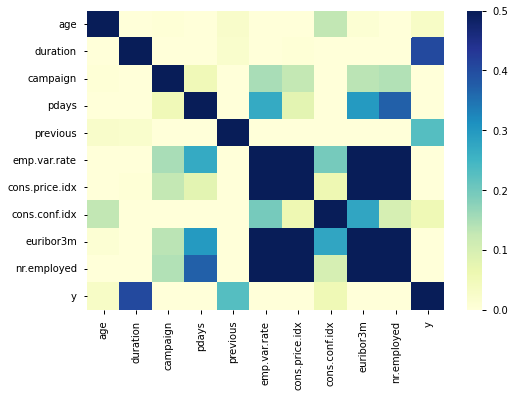

In [ ]:
corr = data.corr()
sns.heatmap(corr, vmin=0, vmax=0.5, cmap='YlGnBu')
plt.show()

In [ ]:
corr.style.background_gradient(cmap='Greens')

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725,0.030399
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703,0.405274
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095,-0.066357
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605,-0.324914
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333,0.230181
emp.var.rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970,-0.298334
cons.price.idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034,-0.136211
cons.conf.idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513,0.054878
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154,-0.307771
nr.employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000,-0.354678


* most correlated with target feature is call duration. Transformation is required to reduce the influence
* higly correlated features (employment rate, consumer confidence index, consumer price index) describe clients state from different social-economic angles. Their variance might support model capacity for generalization.

In [ ]:
# Replacing values with binary ()
data.contact = data.contact.map({'cellular': 1, 'telephone': 0}).astype('uint8') 
data.loan = data.loan.map({'yes': 1, 'unknown': 0, 'no' : 0}).astype('uint8')
data.housing = data.housing.map({'yes': 1, 'unknown': 0, 'no' : 0}).astype('uint8')
data.default = data.default.map({'no': 1, 'unknown': 0, 'yes': 0}).astype('uint8')
data.pdays = data.pdays.replace(999, 0) # replace with 0 if not contact 
data.previous = data.previous.apply(lambda x: 1 if x > 0 else 0).astype('uint8') # binary has contact or not

# binary if were was an outcome of marketing campane
data.poutcome = data.poutcome.map({'nonexistent':0, 'failure':0, 'success':1}).astype('uint8') 

# change the range of Var Rate
data['emp.var.rate'] = data['emp.var.rate'].apply(lambda x: x*-0.0001 if x > 0 else x*1)
data['emp.var.rate'] = data['emp.var.rate'] * -1
data['emp.var.rate'] = data['emp.var.rate'].apply(lambda x: -np.log(x) if x < 1 else np.log(x)).astype('uint8')

# Multiply consumer index 
data['cons.price.idx'] = (data['cons.price.idx'] * 10).astype('uint8')

# change the sign (we want all be positive values)
data['cons.conf.idx'] = data['cons.conf.idx'] * -1

# re-scale variables
data['nr.employed'] = np.log2(data['nr.employed']).astype('uint8')
data['cons.price.idx'] = np.log2(data['cons.price.idx']).astype('uint8')
data['cons.conf.idx'] = np.log2(data['cons.conf.idx']).astype('uint8')
data.age = np.log(data.age)

# less space
data.euribor3m = data.euribor3m.astype('uint8')
data.campaign = data.campaign.astype('uint8')
data.pdays = data.pdays.astype('uint8')

# fucntion to One Hot Encoding
def encode(data, col):
    return pd.concat([data, pd.get_dummies(col, prefix=col.name)], axis=1)

# One Hot encoding of 3 variable 
data = encode(data, data.job)
data = encode(data, data.month)
data = encode(data, data.day_of_week)

# Drop tranfromed features
data.drop(['job', 'month', 'day_of_week'], axis=1, inplace=True)

# Drop the dublicates
data.drop_duplicates(inplace=True) 

In [ ]:
'''Convert Duration Call into 5 category'''
def duration(data):
    data.loc[data['duration'] <= 102, 'duration'] = 1
    data.loc[(data['duration'] > 102) & (data['duration'] <= 180)  , 'duration'] = 2
    data.loc[(data['duration'] > 180) & (data['duration'] <= 319)  , 'duration'] = 3
    data.loc[(data['duration'] > 319) & (data['duration'] <= 645), 'duration'] = 4
    data.loc[data['duration']  > 645, 'duration'] = 5
    return data
duration(data);

In [ ]:
# save target variable before transformation
y = data.y
# Create target encoder object and transoform two value
target_encode = ce.target_encoder.TargetEncoder(cols=['marital', 'education']).fit(data, y)
numeric_dataset = target_encode.transform(data)
# drop target variable
numeric_dataset.drop('y', axis=1, inplace=True)

In [ ]:
display(numeric_dataset.head(3), numeric_dataset.shape, y.shape)

,age,marital,education,default,housing,loan,contact,duration,campaign,pdays,...,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,4.025352,0.101565,0.102490,1,0,0,0,3,1,0,...,0,1,0,0,0,0,1,0,0,0
1,4.043051,0.101565,0.108389,0,0,0,0,2,1,0,...,0,1,0,0,0,0,1,0,0,0
2,3.610918,0.101565,0.108389,1,1,0,0,3,1,0,...,0,1,0,0,0,0,1,0,0,0


(41175, 44)

(41175,)

### Metrics used: ROC_AUC as it allow us to explore models from different angles


In [ ]:
''' Split data on train and test'''
# set global random state
random_state = 11
# split data
X_train, X_test, y_train, y_test = train_test_split(numeric_dataset, y, test_size=0.2, random_state=random_state)
# collect excess data
gc.collect()

271

In [ ]:
display('Length of train and test sets', X_train.shape, y_train.shape, X_test.shape, y_test.shape)

'Length of train and test sets'

(32940, 44)

(32940,)

(8235, 44)

(8235,)

In [ ]:
# We use different classifiers to build a pipeline: LogisticRegression, RandomForestClassifier, KNeighborsClassifier
# DecisionTreeClassifier, BaggingClassifier, SGDClassifier
# set all CPU
n_jobs = -1
pipe_sgd = Pipeline([('sgd', SGDClassifier(random_state=random_state, n_jobs=n_jobs, max_iter=1500))])
pipe_knn = Pipeline([('knn', KNeighborsClassifier(n_jobs=n_jobs))])
pipe_lr = Pipeline([('lr', LogisticRegression(random_state=random_state, n_jobs=n_jobs, max_iter=500))])
pipe_rf = Pipeline([('rf', RandomForestClassifier(random_state=random_state, oob_score=True, n_jobs=n_jobs))])
pipe_dt = Pipeline([('dt', DecisionTreeClassifier(random_state=random_state, max_features='auto'))])
pipe_bag = Pipeline([('bag',BaggingClassifier(base_estimator=SGDClassifier(random_state=random_state, n_jobs=n_jobs, max_iter=1500),\
                                              random_state=random_state,oob_score=True,n_jobs=n_jobs))])

In [ ]:
# set number and parameters for Grid Search
cv = StratifiedKFold(shuffle=True, n_splits=5, random_state=random_state)
# LogisticRegression
grid_params_lr = [{
                'lr__penalty': ['l2'],
                'lr__C': [0.3, 0.6, 0.7],
                'lr__solver': ['sag']
                }]
# RandomForestClassifier
grid_params_rf = [{
                'rf__criterion': ['entropy'],
                'rf__min_samples_leaf': [80, 100],
                'rf__max_depth': [25, 27],
                'rf__min_samples_split': [3, 5],
                'rf__n_estimators' : [60, 70]
                }]
# KNeighborsClassifier
grid_params_knn = [{'knn__n_neighbors': [16,17,18]}]

# DecisionTreeClassifier
grid_params_dt = [{
                'dt__max_depth': [8, 10],
                'dt__min_samples_leaf': [1, 3, 5, 7]
                  }]
# BaggingClassifier
grid_params_bag = [{'bag__n_estimators': [10, 15, 20]}]

# SGDClassifier
grid_params_sgd = [{
                    'sgd__loss': ['log', 'huber'],
                    'sgd__learning_rate': ['adaptive'],
                    'sgd__eta0': [0.001, 0.01, 0.1],
                    'sgd__penalty': ['l1', 'l2', 'elasticnet'], 
                    'sgd__alpha':[0.1, 1, 5, 10]
                    }]

In [ ]:
# Grid search objects
# GridSearchCV is a technique for finding the optimal parameter values from a given set of parameters in a grid. 
# It's essentially a cross-validation technique. The model as well as the parameters must be entered. 
# After extracting the best parameter values, predictions are made.

# for LogisticRegression
gs_lr = GridSearchCV(pipe_lr, param_grid=grid_params_lr,
                     scoring='accuracy', cv=cv) 
# for RandomForestClassifier
gs_rf = GridSearchCV(pipe_rf, param_grid=grid_params_rf,
                     scoring='accuracy', cv=cv)
# for KNeighborsClassifier
gs_knn = GridSearchCV(pipe_knn, param_grid=grid_params_knn,
                     scoring='accuracy', cv=cv)
# for DecisionTreeClassifier
gs_dt = GridSearchCV(pipe_dt, param_grid=grid_params_dt,
                     scoring='accuracy', cv=cv)
# for BaggingClassifier
gs_bag = GridSearchCV(pipe_bag, param_grid=grid_params_bag,
                     scoring='accuracy', cv=cv)
# for SGDClassifier
gs_sgd = GridSearchCV(pipe_sgd, param_grid=grid_params_sgd,
                     scoring='accuracy', cv=cv)

In [ ]:
# models to iterate over
look_for = [gs_lr, gs_rf, gs_knn, gs_dt, gs_bag, gs_sgd]
model_dict = {0:'Logistic_reg', 1:'RandomForest', 2:'Knn', 3:'DesionTree', 4:'Bagging with SGDClassifier', 5:'SGD Class'}

In [ ]:
# set empty dicts and list
result_acc = {}
result_auc = {}
models = []

for index, model in enumerate(look_for):
        start = time.time()
        print('New Model Estimator is {}'.format(model_dict[index]))
        model.fit(X_train, y_train)
        print('best params is {} and score is {}'.format(model.best_params_, model.best_score_))
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        print('ROC_AUC is {} and accuracy rate is {}'.format(auc, model.score(X_test, y_test)))
        print('End Model')
        models.append(model.best_estimator_)
        result_acc[index] = model.best_score_
        result_auc[index] = auc

New Model Estimator is Logistic_reg
best params is {'lr__C': 0.6, 'lr__penalty': 'l2', 'lr__solver': 'sag'} and score is 0.9092592592592593
ROC_AUC is 0.9216519675583464 and accuracy rate is 0.905525197328476
End Model
New Model Estimator is RandomForest
best params is {'rf__criterion': 'entropy', 'rf__max_depth': 25, 'rf__min_samples_leaf': 80, 'rf__min_samples_split': 3, 'rf__n_estimators': 70} and score is 0.9035822707953857
ROC_AUC is 0.926898425815701 and accuracy rate is 0.9038251366120219
End Model
New Model Estimator is Knn
best params is {'knn__n_neighbors': 16} and score is 0.9051001821493625
ROC_AUC is 0.9021734675285782 and accuracy rate is 0.902367941712204
End Model
New Model Estimator is DesionTree
best params is {'dt__max_depth': 8, 'dt__min_samples_leaf': 3} and score is 0.9043715846994536
ROC_AUC is 0.8231990313816664 and accuracy rate is 0.8971463266545234
End Model
New Model Estimator is Bagging with SGDClassifier
best params is {'bag__n_estimators': 15} and score i

In [ ]:
classifiers = ['DesionTree', 'SGD Class', 'KNN', 'Bagging with SGDClassifier', 'Logistic_reg', 'RandomForest']

In [ ]:
a = result_acc.values()
# # model_dict.values()
# list = [str(val) for key, val in result_acc.items()]
# [*sorted(model_dict.values())]

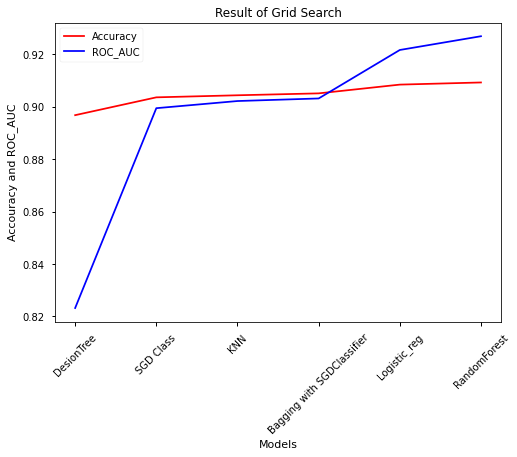

In [ ]:
plt.plot(classifiers, [*sorted(result_acc.values())], c='r')
plt.plot(classifiers, [*sorted(result_auc.values())], c='b')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.ylabel('Accouracy and ROC_AUC')
plt.title('Result of Grid Search')
plt.legend(['Accuracy', 'ROC_AUC'])
plt.style.use('seaborn-notebook')
plt.show();

In [ ]:
acc = [*result_acc.values()]
auc = [*result_auc.values()]
dicct = [*model_dict.values()]
pd.DataFrame(zip(dicct, acc, auc), columns=['Model', 'Accuracy_rate','Roc_auc_rate'])

,Model,Accuracy_rate,Roc_auc_rate
0,Logistic_reg,0.909259,0.921652
1,RandomForest,0.903582,0.926898
2,Knn,0.905100,0.902173
3,DesionTree,0.904372,0.823199
4,Bagging with SGDClassifier,0.908440,0.903157
5,SGD Class,0.896782,0.899445


In [ ]:
data['z_score'] = data['age']

In [ ]:
data.z_score = (data.age-data.age.mean())/data.age.std()
data[['z_score']]

,z_score
0,1.450977
1,1.520692
2,-0.181397
3,0.125679
4,1.450977
...,...
41183,2.495184
41184,0.676174
41185,1.450977
41186,0.501087


In [ ]:
x=data.drop(columns=['y','z_score'])
y=data['y']
x_train,x_test,y_train,y_test=train_test_split(numeric_dataset,y,test_size=0.35)

nom_cols=[1,2,3,8,9]
ord_cols=[4,5,6,7,14]
iter_cols=[0,10,11,12,13,15,16]
simp_cols=[17,18,19]

chart=make_column_transformer((OneHotEncoder(handle_unknown='ignore'),nom_cols),(OrdinalEncoder(),ord_cols),
                                (IterativeImputer(),iter_cols),(SimpleImputer(),simp_cols))
set_config(display='diagram')
chart



ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 [1, 2, 3, 8, 9]),
                                ('ordinalencoder', OrdinalEncoder(),
                                 [4, 5, 6, 7, 14]),
                                ('iterativeimputer', IterativeImputer(),
                                 [0, 10, 11, 12, 13, 15, 16]),
                                ('simpleimputer', SimpleImputer(),
                                 [17, 18, 19])])

In [ ]:
knn=KNeighborsClassifier(n_neighbors=5000)
pipe=make_pipeline(chart,knn)
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [1, 2, 3, 8, 9]),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  [4, 5, 6, 7, 14]),
                                                 ('iterativeimputer',
                                                  IterativeImputer(),
                                                  [0, 10, 11, 12, 13, 15, 16]),
                                                 ('simpleimputer',
                                                  SimpleImputer(),
                                                  [17, 18, 19])])),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=5000))])

In [ ]:
pipe.fit(x_train,y_train)
pred=pipe.predict(x_test)
print('Accuracy of KNN model is', accuracy_score(pred,y_test)*100)

Accuracy of KNN model is 89.08548431862336


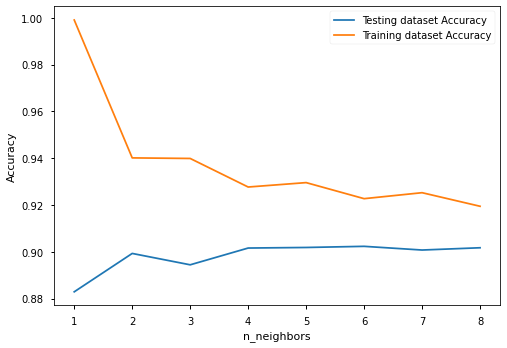

In [ ]:
# Classification using KNN further more
''' Split data on train and test'''
# set global random state
random_state = 11
# split data
X_train, X_test, y_train, y_test = train_test_split(numeric_dataset, y, test_size=0.2, random_state=random_state)
# collect excess data
gc.collect()
 
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over K values
for i, k in enumerate(neighbors):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  # Compute training and test data accuracy
  train_accuracy[i] = knn.score(X_train, y_train)
  test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')

plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()

100%|██████████| 39/39 [01:07<00:00,  1.72s/it]


'max oob 0.9044323011536126 and number of estimators 90'

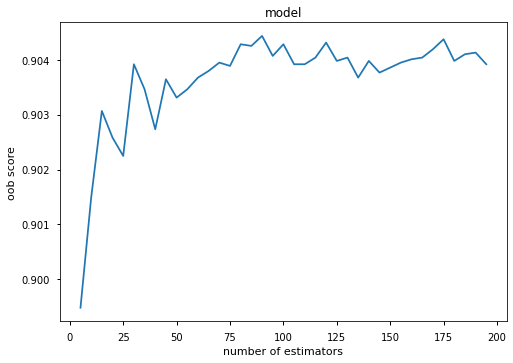

In [ ]:
def graph(model, X_train, y_train):
    obb = []
    est = range(5, 200, 5)
    for i in tqdm(est):
        random_forest = model(n_estimators=i, criterion='entropy', random_state=11, oob_score=True, n_jobs=-1, \
                           max_depth=25, min_samples_leaf=80, min_samples_split=3,)
        random_forest.fit(X_train, y_train)
        obb.append(random_forest.oob_score_)
    display('max oob {} and number of estimators {}'.format(max(obb), est[np.argmax(obb)]))
    plt.plot(est, obb)
    plt.title('model')
    plt.xlabel('number of estimators')
    plt.ylabel('oob score')
    plt.show();
    
graph(RandomForestClassifier, X_train, y_train)

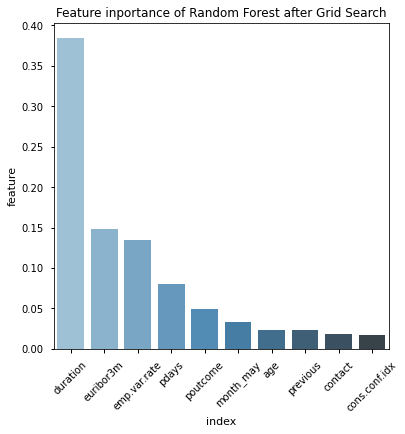

In [ ]:
def feature_importance(model, X_train, y_train):
    
    models = RandomForestClassifier(criterion='entropy', random_state=11, oob_score=True, n_jobs=-1, \
                           max_depth=25, min_samples_leaf=80, min_samples_split=3, n_estimators=70)
    models.fit(X_train, y_train)
    data = pd.DataFrame(models.feature_importances_, X_train.columns, columns=["feature"])
    data = data.sort_values(by='feature', ascending=False).reset_index()
    plt.figure(figsize=[6,6])
    sns.barplot(x='index', y='feature', data=data[:10], palette="Blues_d")
    plt.title('Feature inportance of Random Forest after Grid Search')
    plt.xticks(rotation=45)
    plt.show();
    
feature_importance(RandomForestClassifier, X_train, y_train)